Our goal is to now create a model that will take a new batch of college football running backs and determine which players should be scouted as potential draft choices. While we will change scoring metrics on occasion, we will consistently refer back to the precision and recall for True (True being the designation given to a player that should be scouted). If a team did not have a lot of scouting rescources, they would prefer models with a high amount of precision since this would tell them that most of the players they observe will be worthwhile in pursuing. If a team does have a lot of scouting resources, they would prefer models with a high amount of recall since this would tell them that they would not likely overlook a potential star player. 

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score #or accuracy_score
from sklearn.preprocessing import scale

clg = pd.read_csv('college_avgs_clean.csv')

In [2]:
clg.head()

,Att,Gain,Loss,Yds,Avg,TD,Player,Made NFL
0,160.0,804.0,19.0,785.0,4.910,7.0,A.J. Ouellette,False
1,187.0,1131.5,34.0,1097.5,6.175,10.0,Aaron Green,False
2,246.5,1403.0,52.0,1351.0,5.505,15.5,Adam Muema,False
3,192.0,935.0,47.5,887.5,4.625,7.5,Adam Robinson,False
4,173.0,1123.5,39.0,1084.5,6.265,10.0,Adonis Thomas,False


In [3]:
clg = clg.drop('Player', axis=1)
clg.head()

,Att,Gain,Loss,Yds,Avg,TD,Made NFL
0,160.0,804.0,19.0,785.0,4.910,7.0,False
1,187.0,1131.5,34.0,1097.5,6.175,10.0,False
2,246.5,1403.0,52.0,1351.0,5.505,15.5,False
3,192.0,935.0,47.5,887.5,4.625,7.5,False
4,173.0,1123.5,39.0,1084.5,6.265,10.0,False


In [4]:
y = clg['Made NFL'].values
X = clg.drop('Made NFL', axis=1).values
X_scaled = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=24, stratify=y)

In [5]:
pd.Series(y).value_counts(normalize=True)

False    0.658824
True     0.341176
dtype: float64

### Using Accuracy as the Scoring Metric

In [6]:
neighbors = np.arange(1, 11)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

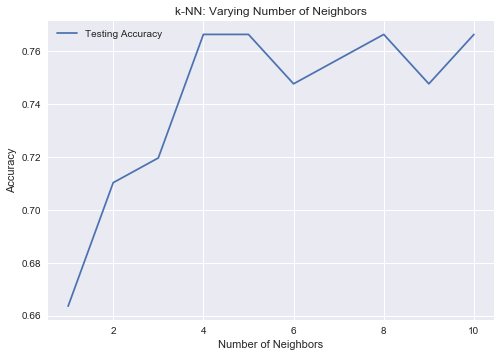

In [7]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [8]:
print('Optimal k = ', test_accuracy.argmax()+1, ', Accuracy = ', test_accuracy.max()*100,'%')

Optimal k =  4 , Accuracy =  76.6355140187 %


In [9]:
from sklearn.model_selection import GridSearchCV
forest = RandomForestClassifier(random_state=42)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 10],'min_samples_leaf':np.arange(1,21), 'class_weight':('balanced','balanced_subsample',None), 'max_features':np.arange(1,7)}

cv = GridSearchCV(forest, param_grid = parameters, scoring='accuracy')
cv.fit(X_train, y_train)
print('Best Score: ', cv.best_score_)
print('Best Parameters: ', cv.best_params_)

Best Score:  0.764150943396
Best Parameters:  {'class_weight': None, 'max_features': 1, 'min_samples_leaf': 9, 'n_estimators': 5}


Comparing our *knn*-classifier to our random forest classifier, we are seeing comparable results using the accuracy metric. Let us see what insights we can gleam from observing precision and recall.

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

knn = KNeighborsClassifier(n_neighbors = test_accuracy.argmax() + 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[66  4]
 [21 16]]
             precision    recall  f1-score   support

      False       0.76      0.94      0.84        70
       True       0.80      0.43      0.56        37

avg / total       0.77      0.77      0.74       107



The precision/recall reports paint an interesting picture here. We see that 80% of the players that the model tells us to look at will actually be worth looking at (from precision on True), which is good. However, only 43% of the players we should be finding are in our results, meaning that we miss a lot of potential stars (from recall on True). Let's see if our forest model is any better.

In [11]:
y_pred = cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[60 10]
 [20 17]]
             precision    recall  f1-score   support

      False       0.75      0.86      0.80        70
       True       0.63      0.46      0.53        37

avg / total       0.71      0.72      0.71       107



While our forest model provides a slight increase on recall, it does so at a steep cost to precision. This is enough of a distinciton to say that we would prefer to use our knn classifier in this case. 

### Using ROC AUC as the Scoring Metric

In [12]:
neighbors = np.arange(1, 11)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute different metric.
    y_test_pred = knn.predict(X_test)
    test_accuracy[i] = roc_auc_score(y_test, y_test_pred)

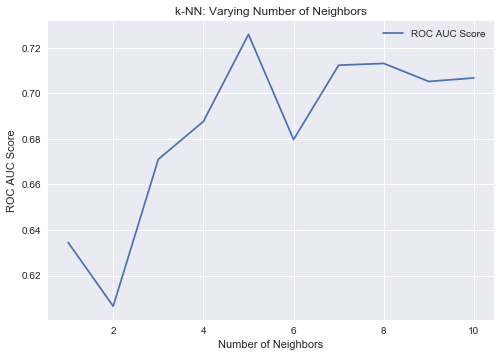

In [13]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'ROC AUC Score')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC AUC Score')
plt.show()

In [14]:
print('Optimal k = ', test_accuracy.argmax()+1, ', ROC AUC Score = ', test_accuracy.max())

Optimal k =  5 , ROC AUC Score =  0.725868725869


In [15]:
forest = RandomForestClassifier(random_state=42)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 10],'min_samples_leaf':np.arange(1,21), 'class_weight':('balanced','balanced_subsample',None), 'max_features':np.arange(1,7)}

cv = GridSearchCV(forest, param_grid = parameters, scoring='roc_auc')
cv.fit(X_train, y_train)
print('Best ROC AUC Score: ', cv.best_score_)
print('Best Parameters: ', cv.best_params_)

Best ROC AUC Score:  0.770238095238
Best Parameters:  {'class_weight': 'balanced_subsample', 'max_features': 3, 'min_samples_leaf': 9, 'n_estimators': 3}


In [16]:
knn = KNeighborsClassifier(n_neighbors = test_accuracy.argmax() + 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[60 10]
 [15 22]]
             precision    recall  f1-score   support

      False       0.80      0.86      0.83        70
       True       0.69      0.59      0.64        37

avg / total       0.76      0.77      0.76       107



In [17]:
y_pred = cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[50 20]
 [13 24]]
             precision    recall  f1-score   support

      False       0.79      0.71      0.75        70
       True       0.55      0.65      0.59        37

avg / total       0.71      0.69      0.70       107



While we ended up with higher recalls for True, we also ended up with lower precisions for True on both models. 

### Using F1 Score as the Scoring Metric

In [18]:
from sklearn.metrics import f1_score
neighbors = np.arange(1, 11)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute different metric.
    y_test_pred = knn.predict(X_test)
    test_accuracy[i] = f1_score(y_test, y_test_pred)

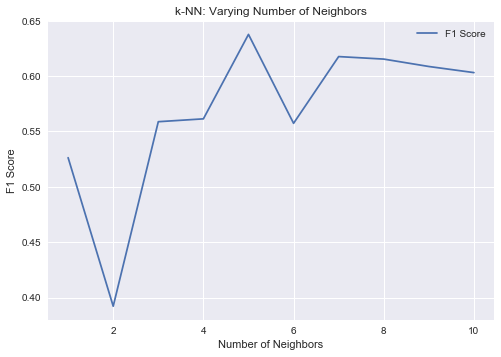

In [19]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'F1 Score')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score')
plt.show()

In [20]:
print('Optimal k = ', test_accuracy.argmax()+1, ', F1 Score = ', test_accuracy.max())

Optimal k =  5 , F1 Score =  0.63768115942


In [21]:
forest = RandomForestClassifier(random_state=42)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 10],'min_samples_leaf':np.arange(1,21), 'class_weight':('balanced','balanced_subsample',None), 'max_features':np.arange(1,7)}

cv = GridSearchCV(forest, param_grid = parameters, scoring='f1')
cv.fit(X_train, y_train)
print('Best F1 Score: ', cv.best_score_)
print('Best Parameters: ', cv.best_params_)

Best F1 Score:  0.638504204688
Best Parameters:  {'class_weight': 'balanced', 'max_features': 3, 'min_samples_leaf': 8, 'n_estimators': 5}


In [22]:
knn = KNeighborsClassifier(n_neighbors = test_accuracy.argmax() + 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[60 10]
 [15 22]]
             precision    recall  f1-score   support

      False       0.80      0.86      0.83        70
       True       0.69      0.59      0.64        37

avg / total       0.76      0.77      0.76       107



In [23]:
y_pred = cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[49 21]
 [11 26]]
             precision    recall  f1-score   support

      False       0.82      0.70      0.75        70
       True       0.55      0.70      0.62        37

avg / total       0.73      0.70      0.71       107



The random forest model seems to have given us the best recall score for true so far. 

### Using Precision on 'True' as the Scoring Metric

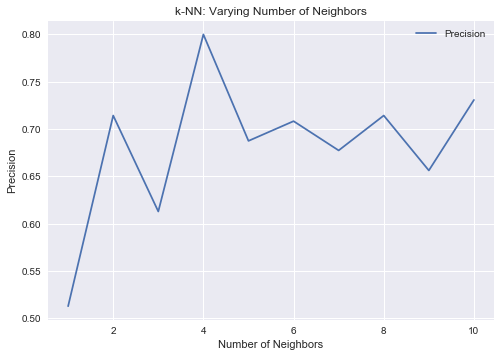

Optimal k =  4 , Precision Score =  0.8
Best Precision Score:  0.693209876543
Best Parameters:  {'class_weight': None, 'max_features': 1, 'min_samples_leaf': 9, 'n_estimators': 5}
Confusion Matrix and Classification Report for Best KNN Classifier
[[66  4]
 [21 16]]
             precision    recall  f1-score   support

      False       0.76      0.94      0.84        70
       True       0.80      0.43      0.56        37

avg / total       0.77      0.77      0.74       107

Confusion Matrix and Classification Report for Best Random Forest Classifier
[[60 10]
 [20 17]]
             precision    recall  f1-score   support

      False       0.75      0.86      0.80        70
       True       0.63      0.46      0.53        37

avg / total       0.71      0.72      0.71       107



In [24]:
from sklearn.metrics import precision_score
neighbors = np.arange(1, 11)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute different metric.
    y_test_pred = knn.predict(X_test)
    test_accuracy[i] = precision_score(y_test, y_test_pred)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Precision')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Precision')
plt.show()

print('Optimal k = ', test_accuracy.argmax()+1, ', Precision Score = ', test_accuracy.max())

forest = RandomForestClassifier(random_state=42)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 10],'min_samples_leaf':np.arange(1,21), 'class_weight':('balanced','balanced_subsample',None), 'max_features':np.arange(1,7)}

cv = GridSearchCV(forest, param_grid = parameters, scoring='precision')
cv.fit(X_train, y_train)
print('Best Precision Score: ', cv.best_score_)
print('Best Parameters: ', cv.best_params_)

knn = KNeighborsClassifier(n_neighbors = test_accuracy.argmax() + 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Confusion Matrix and Classification Report for Best KNN Classifier')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred = cv.predict(X_test)
print('Confusion Matrix and Classification Report for Best Random Forest Classifier')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

If a organization was attempting to optimize for precision on 'True', I would recommend that they use the knn model that we just found.

### Using Recall on 'True' as the Scoring Metric

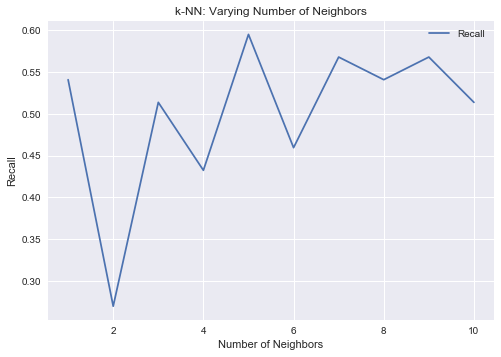

Optimal k =  5 , Recall Score =  0.594594594595
Best Recall Score:  0.740740740741
Best Parameters:  {'class_weight': 'balanced', 'max_features': 4, 'min_samples_leaf': 19, 'n_estimators': 1}
Confusion Matrix and Classification Report for Best KNN Classifier
[[60 10]
 [15 22]]
             precision    recall  f1-score   support

      False       0.80      0.86      0.83        70
       True       0.69      0.59      0.64        37

avg / total       0.76      0.77      0.76       107

Confusion Matrix and Classification Report for Best Random Forest Classifier
[[56 14]
 [14 23]]
             precision    recall  f1-score   support

      False       0.80      0.80      0.80        70
       True       0.62      0.62      0.62        37

avg / total       0.74      0.74      0.74       107



In [25]:
from sklearn.metrics import recall_score
neighbors = np.arange(1, 11)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute different metric.
    y_test_pred = knn.predict(X_test)
    test_accuracy[i] = recall_score(y_test, y_test_pred)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Recall')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Recall')
plt.show()

print('Optimal k = ', test_accuracy.argmax()+1, ', Recall Score = ', test_accuracy.max())

forest = RandomForestClassifier(random_state=42)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 10],'min_samples_leaf':np.arange(1,21), 'class_weight':('balanced','balanced_subsample',None), 'max_features':np.arange(1,7)}

cv = GridSearchCV(forest, param_grid = parameters, scoring='recall')
cv.fit(X_train, y_train)
print('Best Recall Score: ', cv.best_score_)
print('Best Parameters: ', cv.best_params_)

knn = KNeighborsClassifier(n_neighbors = test_accuracy.argmax() + 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Confusion Matrix and Classification Report for Best KNN Classifier')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred = cv.predict(X_test)
print('Confusion Matrix and Classification Report for Best Random Forest Classifier')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

This model had the supposed best recall for 'True'. However, the random forest model that we discovered for optimizing the F1 score resulted in a higher recall for 'True'. 